# The perception of the Afghan situation in the Social Media debate – An exploratory text mining study
**Luigi Arminio**

The end of the War in Afghanistan may be considered the most meaningful
geopolitical event of the latest years. Due to the long duration of this war, as well as the strong inolvement of Western political actors in this conflict, the fall of Kabul and the withdrawal of the US troops from the country generated a sizeable debate in the Western context, which has resulted in a large quantity of posts concerning the end of this war released on social media platforms like Twitter.<BR>
For this reason, I chose to explore the tweets released during the summer 2021, in the period between them 6th of August and the 25th of August.<BR>
The data have been collected by web scraping, with the *rtweet* package and the Twitter API key permission (see the file scraping_script.R to visualize the scraping procedure). The pattern according to which data have been collected was the occurrence of the hashtag *#afghanistan* and the use of *english* language.
    
After that, text mining techniques have been applied on the corpus of tweets (in particular, **sentiment analysis** and **topic modeling** have been performed on the data).

Down here, the code written to produce the analysis is reported.
    
    
To begin with, it is necessary to load all the useful packages.

In [66]:
#***LOADING USEFUL LIBRARIES
library(quanteda)
library(quanteda.corpora)
library(seededlda)
library(lubridate)
library(rtweet)
library(maps)
library(quanteda.textplots)
library(tidytext) #to load the stop_words dataset
library(ldatuning)
library(topicmodels)
library(dplyr)
library(ggplot2)
library(repr)

In [71]:
#***BASIC OPERATION - DATASET LOADING AND DELETING DUPLICATES***
#Loading the scraped datasets
af1<-readRDS("afghanistan.RDS")
af2<-readRDS("afghanistan2")
af3<-readRDS("afgha3")
#Joining the datasets
afghanistandf<-rbind(af1,af2)
afghanistandf<-rbind(afghanistandf,af3)
#Removing the duplicate rows
afghanistandf<-unique(afghanistandf)

In [112]:
#Visualizing the length of the entire dataset
nrow(afghanistandf)

[1] 210366

The entire dataset has been loaded. It is composed of 210366 units. For example purposes, I reproduced the analysis on a reduced sample (2104 units).<BR>
To produce more accurate results, it is recommended to perform the analysis on the entire dataset.
    

In [73]:
#sampling numbers from 1 to the length of the dataset, to obtain the row numbers of the future sample
rowind<- sample(1:nrow(afghanistandf),2104)

In [74]:
#Generating the sample
afghanistan <- afghanistandf[rowind,]

**EXPLORATORY DATA ANALYSIS**
<BR>
    
We have generated the data for our analysis. Let's visualize the columns of the dataset:

In [115]:
#Visualizing the dataset variables
colnames(afghanistan)

[1] "user_id"                 "status_id"              
 [3] "created_at"              "screen_name"            
 [5] "text"                    "source"                 
 [7] "display_text_width"      "reply_to_status_id"     
 [9] "reply_to_user_id"        "reply_to_screen_name"   
[11] "is_quote"                "is_retweet"             
[13] "favorite_count"          "retweet_count"          
[15] "quote_count"             "reply_count"            
[17] "hashtags"                "symbols"                
[19] "urls_url"                "urls_t.co"              
[21] "urls_expanded_url"       "media_url"              
[23] "media_t.co"              "media_expanded_url"     
[25] "media_type"              "ext_media_url"          
[27] "ext_media_t.co"          "ext_media_expanded_url" 
[29] "ext_media_type"          "mentions_user_id"       
[31] "mentions_screen_name"    "lang"                   
[33] "quoted_status_id"        "quoted_text"            
[35] "quoted_created_at"       "quoted_source"          
[37] "quoted_favorite_count"   "quoted_retweet_count"   
[39] "quoted_user_id"          "quoted_screen_name"     
[41] "quoted_name"             "quoted_followers_count" 
[43] "quoted_friends_count"    "quoted_statuses_count"  
[45] "quoted_location"         "quoted_description"     
[47] "quoted_verified"         "retweet_status_id"      
[49] "retweet_text"            "retweet_created_at"     
[51] "retweet_source"          "retweet_favorite_count" 
[53] "retweet_retweet_count"   "retweet_user_id"        
[55] "retweet_screen_name"     "retweet_name"           
[57] "retweet_followers_count" "retweet_friends_count"  
[59] "retweet_statuses_count"  "retweet_location"       
[61] "retweet_description"     "retweet_verified"       
[63] "place_url"               "place_name"             
[65] "place_full_name"         "place_type"             
[67] "country"                 "country_code"           
[69] "geo_coords"              "coords_coords"          
[71] "bbox_coords"             "status_url"             
[73] "name"                    "location"               
[75] "description"             "url"                    
[77] "protected"               "followers_count"        
[79] "friends_count"           "listed_count"           
[81] "statuses_count"          "favourites_count"       
[83] "account_created_at"      "verified"               
[85] "profile_url"             "profile_expanded_url"   
[87] "account_lang"            "profile_banner_url"     
[89] "profile_background_url"  "profile_image_url"

We have several variables, among which the date of the tweets. Let's visualize the least and the most recent dates of our dataset, to understand the time window taken into consideration in our analysis:

In [125]:
#Visualizing the oldest and the newest tweets
c(min(afghanistan$created_at),max(afghanistan$created_at))

[1] "2021-08-06 12:22:46 UTC" "2021-08-25 21:02:02 UTC"

The time range is between the 6th and the 25th of August. It means that the sample collected the time window of the entire dataset.

Let's visualize the geographical visualization of the tweets with a map:

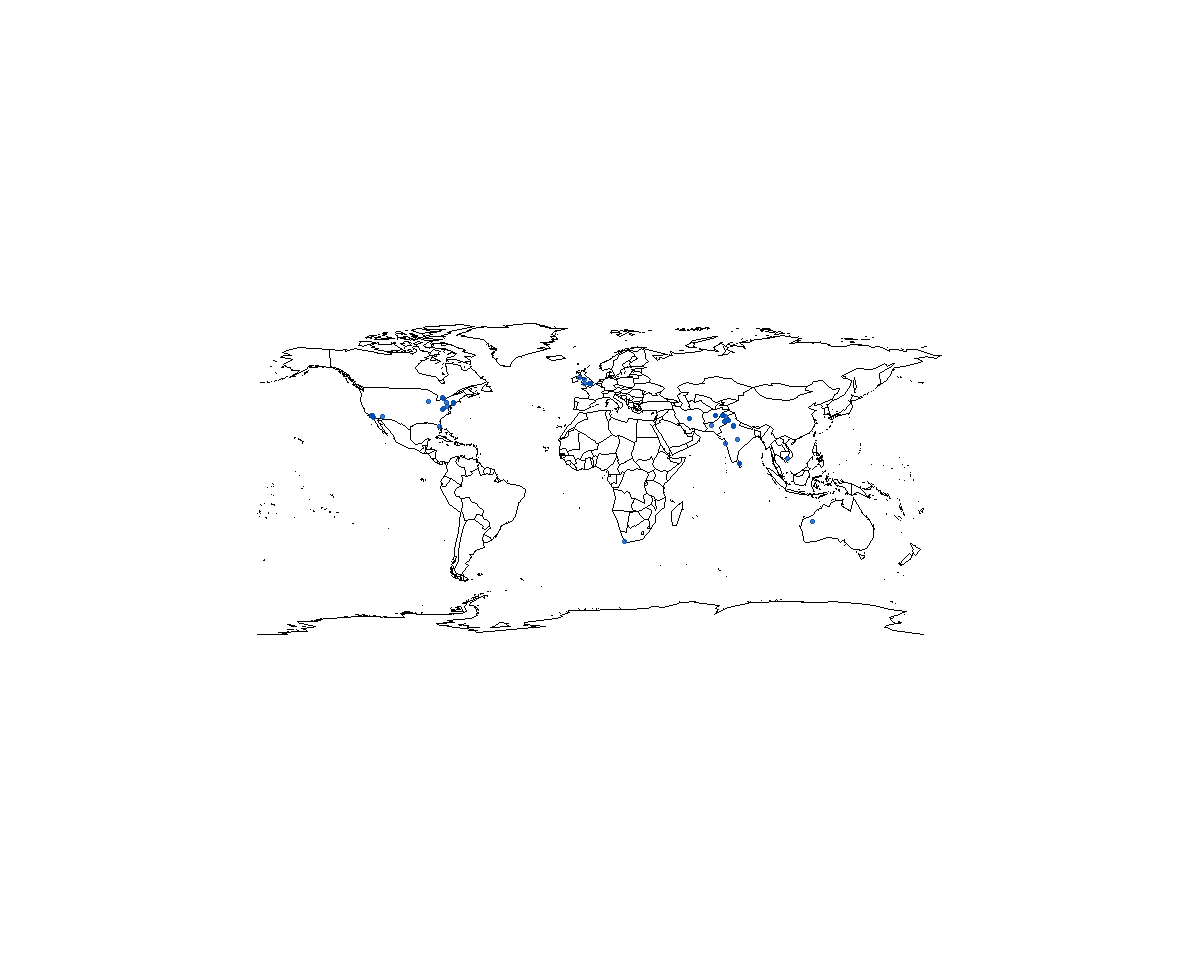

In [138]:
#***EXPLORATORY DATA ANALYSIS - Geographic distribution of the tweets, Top hashtags, Wordcloud***
#Visualizing the geografic distribution of the tweets, in US and in the world in general
datafgh <- lat_lng(afghanistan)
## Plotting boundaries
par(mar = c(0, 0, 0, 0))
maps::map("world", lwd = .8)
## Plotting lat and lng points ; WORLD MAP
with(datafgh, points(lng, lat, pch = 20, cex = .75, col = rgb(0, .3, .7, .75)))


As we can see, there is a relevant presence of tweets in the UK area (which is understandable, to the extent that these tweets were written in English), but also in territories that are close to Afghanistan (Pakistan, India). Some tweets also arrive from US.

Let's visualize the **most frequent hashtags**:

In [80]:
#Hashtags analysis
#momentaneous tokenization for the most frequent hashtags and users:
testomom <- afghanistan$text
tweet_dfm <- tokens(testomom, remove_punct = TRUE) %>%
  dfm()
#Extract most common hashtags
tag_dfm <- dfm_select(tweet_dfm, pattern = "#*")
toptag <- names(topfeatures(tag_dfm, 50))
head(toptag)

[1] "#afghanistan"       "#taliban"           "#kabul"            
[4] "#pakistan"          "#biden"             "#afghanistancrisis"

As we can see, in addition to hashtags strictly related to Afghanistan, we find "#biden", which should be related to the fact that people discuss about the US withdrawal, and "#pakistan", which can be related to the consistent presence of tweets from Pakistan. Besides, Pakistan has been defined as the "Afghanistan's largest trade partner"<sup>1</sup>.

Let's visualize the **most frequent words**

In [81]:
names(topfeatures(tweet_dfm, 50))

[1] "the"          "#afghanistan" "to"           "in"           "of"          
 [6] "and"          "a"            "is"           "for"          "#taliban"    
[11] "on"           "are"          "from"         "that"         "taliban"     
[16] "with"         "amp"          "this"         "we"           "it"          
[21] "as"           "afghanistan"  "will"         "they"         "be"          
[26] "us"           "not"          "by"           "you"          "has"         
[31] "have"         "#kabul"       "people"       "i"            "afghan"      
[36] "our"          "about"        "at"           "all"          "was"         
[41] "their"        "what"         "who"          "now"          "but"         
[46] "no"           "out"          "s"            "country"      "more"

As we can see, the most frequent words are mainly stopwords. This is not so much informative, let's drop them and visualize a wordcloud:

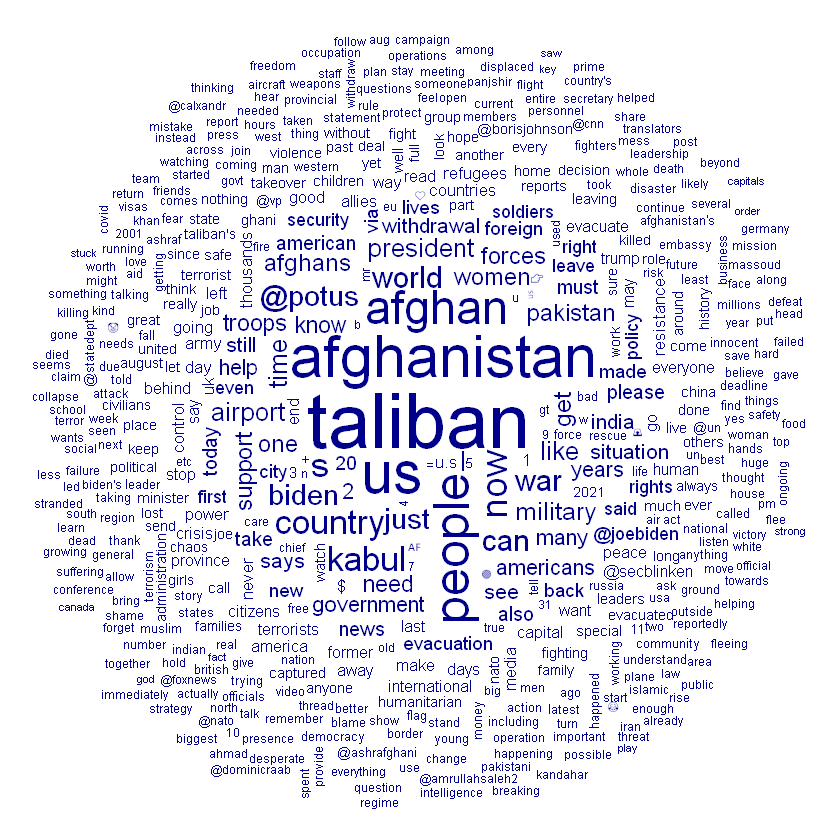

In [82]:
#Basic cleaning of the matrix for the wordcloud
tweet_dfm2 <- dfm_remove(tweet_dfm,pattern=stopwords("en")) #delete stopwords
tweet_dfm2 <- dfm_remove(tweet_dfm2,pattern="#*") #delete hashtags
tweet_dfm2 <- dfm_remove(tweet_dfm2,pattern="amp")#delete nuisance word
#Plotting the wordcloud
textplot_wordcloud(tweet_dfm2)


In [90]:
names(topfeatures(tweet_dfm2, 20))

[1] "taliban"     "afghanistan" "us"          "people"      "afghan"     
 [6] "now"         "s"           "country"     "kabul"       "war"        
[11] "can"         "world"       "just"        "@potus"      "biden"      
[16] "president"   "like"        "time"        "airport"     "military"

The main words are mostly related to Afghanistan, but also to the US politics.


**TEXT CLEANING, STEMMING AND TOKENIZATION**

To do a deeper analysis, we need to furtherly clean the text:

In [84]:
#CLEANING THE TEXT - Deep cleaning activity
testo<-afghanistan$text
#us can mean more than one thing; when it is caps lock it refers to unitedstates
testo = gsub("US", "unitedstates", testo)  
testo<-tolower(testo)
testo<-iconv(testo, to="ASCII", sub=" ")
testo <- gsub("amp;", "", testo)# Remove "amp;", and "\n"" wich are not part of the tweet
testo <- gsub("(RT|via)((?:\\b\\W*@\\w+)+)", "", testo)  # Remove the "RT" (retweet) and usernames
testo<- gsub("https?://.+", "", testo)
testo = gsub("http.+ |http.+$", " ", testo)  # Remove html links
testo = gsub("http[[:alnum:]]*", "", testo)
testo = gsub("[[:punct:]]", " ", testo)  # Remove punctuation
testo = gsub("[ |\t]{2,}", " ", testo)  # Remove tabs
testo = gsub("^ ", "", testo)  # Leading blanks
testo = gsub(" $", "", testo)  # Lagging blanks
testo = gsub(" +", " ", testo) # General spaces 
#Remove most frequent and general words
testo = gsub("taliban", "", testo) 
testo = gsub("afghanistan", "", testo)  
testo = gsub("afghan", "", testo) 
#defining the corpus
afghanistancorpus<-corpus(testo)

In [85]:
#Preparing the date variable to analyze the sentiment evolution over time
date<-afghanistan$created_at 
date<-as.Date(date)

In the successive step, we will also *stem* our corpus of tweets:

In [86]:
#Tokeizing the corpus
toks_afg <- quanteda::tokens(afghanistancorpus, remove_punct = TRUE, remove_numbers = TRUE, remove_symbol = TRUE)
toks_afg <- tokens_remove(toks_afg, pattern = c(stopwords("en"),stop_words$word))
#Stemming the tokens
toks_afg<-quanteda::tokens_wordstem(toks_afg)
toks_afg$date<-date #adding the date
#From tokens to Document feature matrix
dfmat_afg<-dfm(toks_afg)

**SENTIMENT ANALYSIS**
<BR>
After having explored and cleaned the text, we want to visualize the evolution of the sentiment in the public discussion about the Afghan situation. To do this, we use the Lexicoder Dictionary, which is considered a good dictionary to analyze political communication:

In [87]:
#SENTIMENT ANALYSIS with LSD Dictionary:
#selecting only positive and negative categories
data_dictionary_LSD2015_pos_neg <- data_dictionary_LSD2015[1:2]
toks_afg_lsd <- tokens_lookup(toks_afg, dictionary = data_dictionary_LSD2015_pos_neg)
#creating a document DFM and grouping it by day
dfmat_afg_lsd <- dfm(toks_afg_lsd) %>% 
  dfm_group(groups = date)

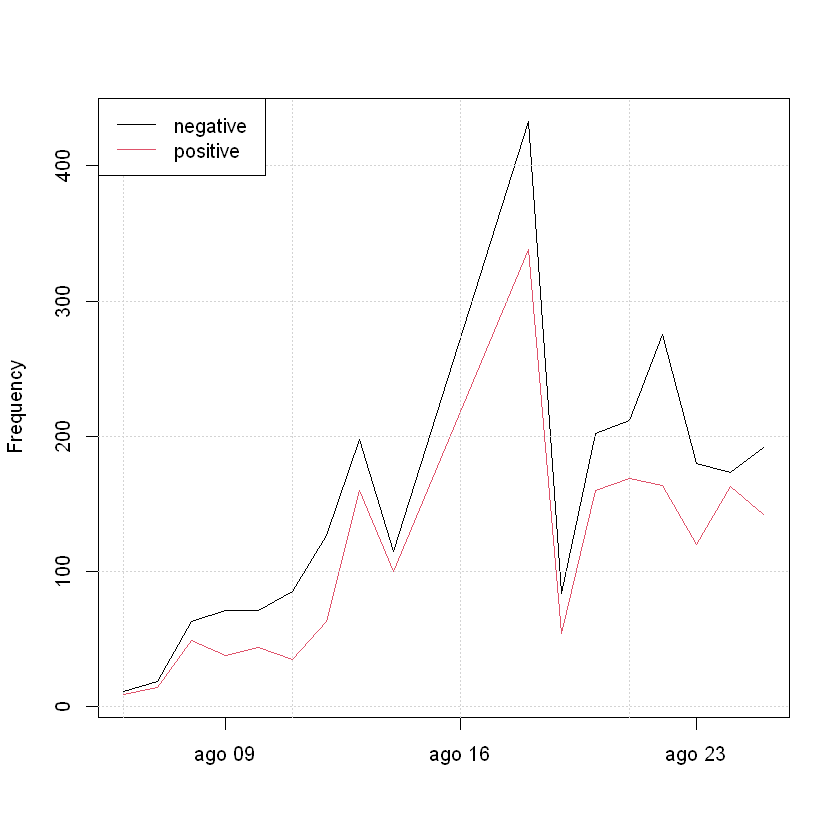

In [88]:
#plotting sentiment evolution over the days:
matplot(dfmat_afg_lsd$date, dfmat_afg_lsd, type = "l", lty = 1, col = 1:2,
        ylab = "Frequency", xlab = "")
grid()
legend("topleft", col = 1:2, legend = colnames(dfmat_afg_lsd), lty = 1, bg = "white")

As we can see from the plot, the frequency of negative words have always been higher than the one of positive words, but in the most recent days, this gap has grown.

**TOPIC ANALYSIS - LDA**
<BR>
After having visualized the sentiment of the tweets and its evolution over time, it is interesting to visualize the main topics that characterized the discussion.
This can be done through Latent Dirichlet Allocation, which is an unsupervised model which allows to partition the words of our corpus into *k* mutually inclusive clusters of words, which are called topics. Since we have not an exact number of topics in a deterministic sense, to decide this number, we can go through hyperparameter tuning:

fit models... done.
calculate metrics:
  Griffiths2004... done.
  CaoJuan2009... done.
  Arun2010... done.
  Deveaud2014... done.


Warning message:
"`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead."


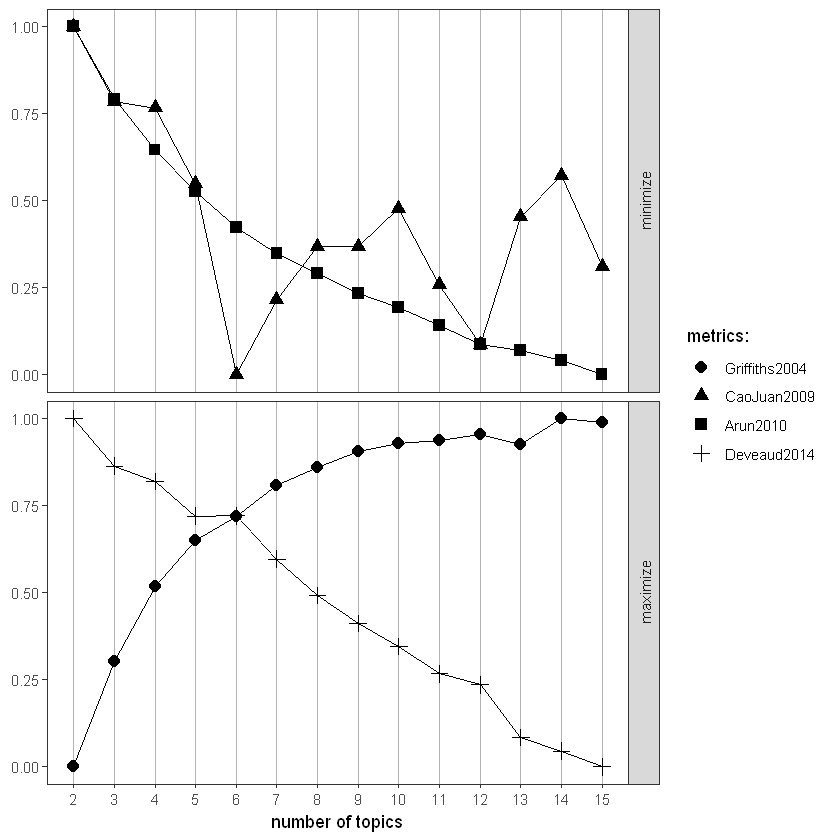

In [89]:
#***TOPIC MODELING - LDA***
#*Hyperparameter tuning for the optimal number of clusters
#Trimming the dfm
dfm.trim <- dfm_trim(dfmat_afg, min_termfreq = 2)
#Converting the matrix to a topic model object for the tuning
dfm2topicmodels <- convert(dfm.trim, to = "topicmodels")
#Finding the optimal number of models through H. Tuning:
ldatuning.metrics <- FindTopicsNumber(dfm2topicmodels, topics = seq(from = 2, to = 15, by = 1), metrics = c("Griffiths2004", "CaoJuan2009", "Arun2010", "Deveaud2014"), method = "Gibbs", control = list(seed = 77), mc.cores = 2L, verbose = TRUE
)
#Plotting to search the best tradeoff
FindTopicsNumber_plot(ldatuning.metrics)
#Several models have been attempted; the best substantial results were with 6 topics

The point in which *maximize* metrics and *minimize* metrics meet in the best way is at the number 6. Hence, let's generate a 6-topics LDA model:

In [91]:
#Final model
set.seed(68)
tmod_lda6 <- textmodel_lda(dfm.trim, k = 6)
seededlda::terms(tmod_lda6, 10)
saveRDS(tmod_lda6,"topicmodel_lda6")

topic1,topic2,topic3,topic4,topic5,topic6
women,biden,kabul,unitedst,pakistan,kabul
live,american,report,war,india,evacu
peopl,unitedst,forc,militari,terrorist,peopl
world,withdraw,panjshir,america,countri,airport
support,joebiden,citi,armi,china,unitedst
sanctionpakistan,trump,presid,power,refuge,thousand
countri,potunitedst,leader,countri,support,kabulairport
human,troop,capit,world,iran,minist
right,presid,captur,time,russia,oper
situat,crisi,provinc,nato,peac,militari


Since the number of topics is quite small, instead of labeling each topic according to the most likely words, we can qualitatively explore the table to give a name to each topic.
In the first case, we mainly have words that seem to refer to concerns related to women rights and human rights in general. The name will be *Women & Huamn Rights*.<BR>
In the second topic, we have references to the US internal policy (which can refer to the role of the US governments in this war and its end). The name will be *US politics*.<BR>
In the third one, references are to Kabul in general (maybe referred to its fall in the war). I name it *Kabul*.<BR>
The fourth has references to the US with terms that refers to its army/military force. I name it *US Army*.<BR>
In the fifth, we have references to several countries outside Afghanistan, most of them close or bordering to Afghanistn. In this sense, these words seems to refer to the geopolitical context around Afghanistan. The name will be *Geopolitical Context*.<BR>
The last topic has instead references to Kabul, but the words seems to refer more to the evacuation from Kabul and from its Airport. The name will be *Kabul evacuation*.

In [95]:
#Visualizing the topic of the texts
modmatr<-data.frame(tmod_lda6$theta)
#vectorizing the most likely topic for each tweet according to the THETA parameter
topicsrows<-colnames(modmatr)[apply(modmatr,1,which.max)]
#assign the most likely topic to each tweet in the original dataset
afghanistan$topic <- topicsrows

In [ ]:
#Renaming the topics according to the main concepts
afghanistan$topic[afghanistan$topic=="topic1"]<- "Women & Human Rights"
afghanistan$topic[afghanistan$topic=="topic2"]<- "US politics"
afghanistan$topic[afghanistan$topic=="topic3"]<- "Kabul"
afghanistan$topic[afghanistan$topic=="topic4"]<- "US Army"
afghanistan$topic[afghanistan$topic=="topic5"]<- "Geopolitical Context"
afghanistan$topic[afghanistan$topic=="topic6"]<- "Kabul evacuation"

In [101]:
#Creating a table to show the frequency distribution of the different topics:
freqtabtopics <- table(afghanistan$topic)
freqtabtopics <- as.data.frame(freqtabtopics)
colnames(freqtabtopics) <- c("Topic","N_tweets")
freqtabtopics

Topic,N_tweets
<fct>,<int>
Geopolitical Context,274
Kabul,355
Kabul evacuation,280
US Army,319
US politics,403
Women & Human Rights,473


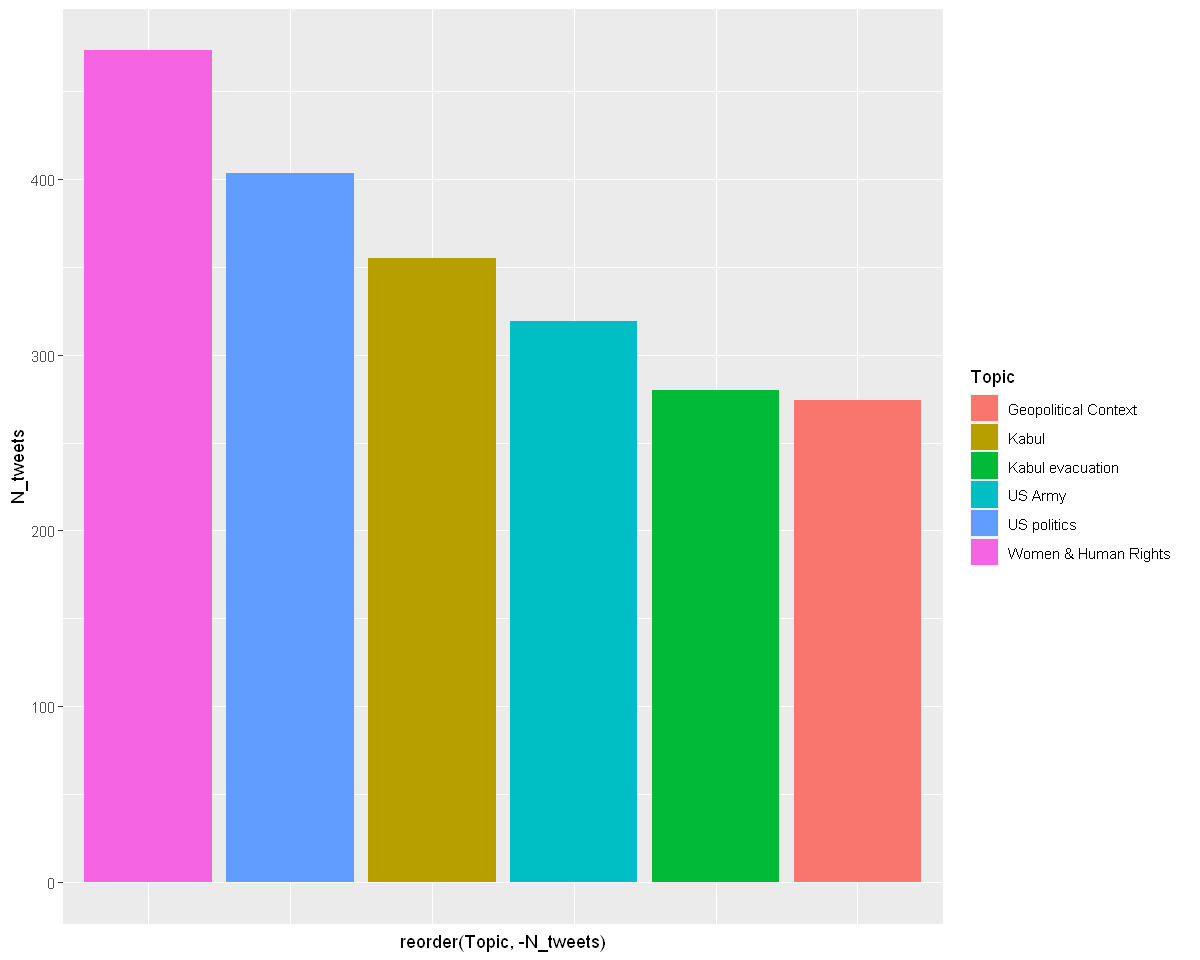

In [139]:
#Plotting the frequency distribution of the topics through a colored bar chart:
ggplot(freqtabtopics,aes(reorder(Topic,-N_tweets),N_tweets,fill=Topic))+geom_bar(stat="identity")+
  theme(axis.ticks.x = element_blank(), axis.text.x = element_blank())

As we can see from this plot, the most represented topic is about Human Rights and Women Rights concerns. Subsequently, we have the US Politics, and then Kabul. 

Now let's explore the evolution, in terms of frequency, over time, of the topics:

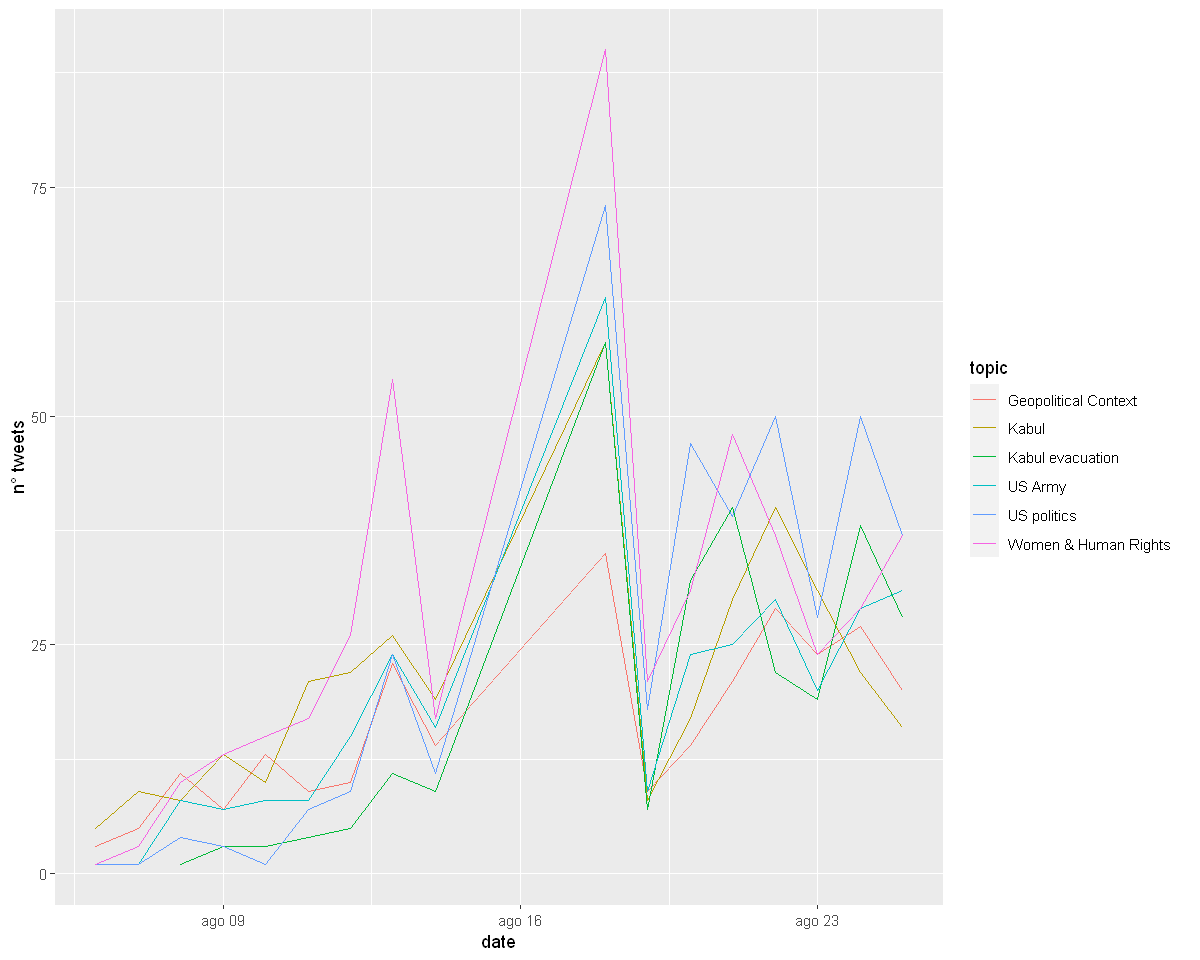

In [100]:
#Plotting the evolution over time of the topics
#code to improve the visualization
options(repr.plot.width=10, repr.plot.height=8)

afghanistan %>%
  mutate(created_at = lubridate::ymd_hms(created_at), 
         date = as.Date(created_at)) %>%
  count(date, topic) %>%
  ggplot(aes(date, n, color = topic)) + geom_line()+
  labs(y="n° tweets")


#PLOT 5: Plotting the frequency distribution of the topics through a colored bar chart:
library(ggplot2)
ggplot(freqtabtopics,aes(Topic,N_tweets,fill=Topic))+geom_bar(stat="identity")+
  theme(axis.ticks.x = element_blank(), axis.text.x = element_blank())



By this plot, we can see how the topic "Women & Human Rights has ad its peak few days after the 16th of August, and than dropped, being overcame by tweets about US Politics

# Sources

<sup>1</sup> https://mofa.gov.pk/testing-language/


In [65]:
nrow(afghanistan)

[1] 210366